# Tarea 2 - Parte 1
# INF477 Redes Neuronales Artificiales I-2018

Profesor: Dr. Ricardo Ñanculef -- 
Ayudante: Francisco Mena

Alumnos:
- Jose Caimapo, jose.caimapo.12@sansano.usm.cl

- Eliana Providel Godoy, eprovide@inf.utfsm.cl

In [271]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error
import math

import time

np.random.seed(7) ## semilla

### a) Función que carga los datos, los divide en 1500 de entrenamiento y el 500 de pruebas, y escalado de datos para trabajar con redes recurrentes.

In [272]:
## Función que carga los datos y escala
def data(name_f, num):    
    # Leer archivo CSV extrayendo la columna 1, y luego guardando solo los primeros num datos
    dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[:num]
    
    # Transforma todos los datos a tipo float32
    dataframe[:] = dataframe[:].astype('float32')
    
    # en df_train guarda los primeros 1500 valores --- posicion 0 hasta 1500 y
    # en df_test guarda los restantes  500 valores --- posicion 1500 hasta el final
    df_train, df_test = dataframe[:1500].values, dataframe[1500:].values
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
    stream_train_scaled = scaler.transform(df_train)
    stream_test_scaled  = scaler.transform(df_test)
    return scaler, dataframe, stream_train_scaled, stream_test_scaled

** Utilizando la función data (definida anteriormente) y verificando la distribución de los datos **

In [273]:
name_f = "time_series_data.csv"
num = 2000

scaler, dataframe,stream_train_scaled,stream_test_scaled = data(name_f,num)
stream_train_scaled_Orig = np.copy(stream_train_scaled) ##para tener una copia de los datos originales.
stream_test_scaled_Orig = np.copy(stream_test_scaled)   ##para tener una copia de los datos originales.

,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
count,2000.000000
mean,11.148250
std,4.194983
min,0.000000
25%,8.100000
50%,11.000000
75%,14.000000
max,26.299999


,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,10.0


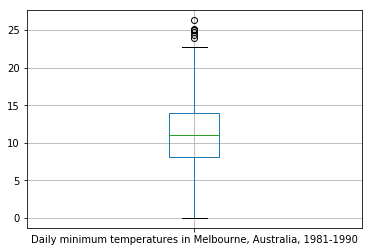

In [274]:
##  Describiendo el dataframe
dataframe.describe()
dataframe.mode()
dataframe.boxplot()

Datos de entrenamiento escalados
Max: 1.0
Min: 0.0
Len: 1500
Datos de prueba escalados
Max: 0.851711
Min: 0.0114068
Len: 500


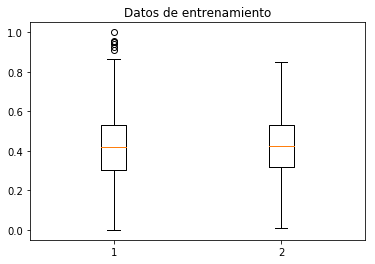

In [276]:
## Para los datos de entrenamiento y prueba escalados

print("Datos de entrenamiento escalados")
print("Max: %s" % (stream_train_scaled.max()))
print("Min: %s" % (stream_train_scaled.min()))
print("Len: %s" % (len(stream_train_scaled)))

print("Datos de prueba escalados")
print("Max: %s" % (stream_test_scaled.max()))
print("Min: %s" % (stream_test_scaled.min()))
print("Len: %s" % (len(stream_test_scaled)))

scaled_data = [stream_train_scaled,stream_test_scaled]
_ = plt.title("Datos de entrenamiento")
_ = plt.boxplot(scaled_data)


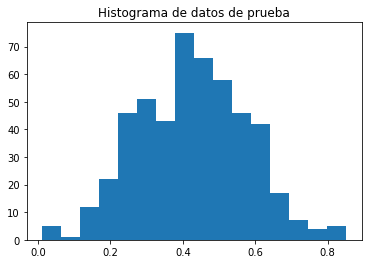

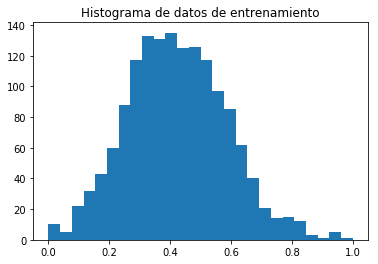

In [277]:
hist, bin_edges = np.histogram(stream_test_scaled,bins='auto')
_ = plt.hist(stream_test_scaled, bins=bin_edges)
_ = plt.title("Histograma de datos de prueba")
plt.show()

hist, bin_edges = np.histogram(stream_train_scaled,bins='auto')
_ = plt.hist(stream_train_scaled, bins=bin_edges)
_ = plt.title("Histograma de datos de entrenamiento")
plt.show()

### b)  Función que recibe una secuencia de valores y la transforma en dos arreglos dataX (input) y dataY (targets) donde el número de características de la matriz de entrada (columnas) es el número de tiempos que se considera como información (lag).

### lag es el número de períodos los que serán usados para la predicción.

In [278]:
def create_dataset(dataset,lag=1):
    # filas
    m = len(dataset) - lag    
    # columnas
    n = lag + 1    
    data = np.array( [ dataset[x:x+lag+1].flatten() for x in range(0, m) ] )
    dataY=data[:,lag]
    dataX=np.delete(data,lag,1)
    return dataX, dataY


In [279]:
## Ejemplo según enunciado
dset_prueba = np.array([[20.7], [17.9], [18.8], [14.6], [15.8], [15.8], [10.1]])
dataX, dataY = create_dataset(dset_prueba, 3)

print("dataX %s\n"  % (dataX))
print("dataY %s"  % (dataY))

dataX [[ 20.7  17.9  18.8]
 [ 17.9  18.8  14.6]
 [ 18.8  14.6  15.8]
 [ 14.6  15.8  15.8]]

dataY [ 14.6  15.8  15.8  10.1]


### c) Utilizando la función anterior se generan los  conjuntos de prueba y entrenamiento

In [293]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY   = create_dataset(stream_test_scaled , lag)

## Verificando las dimensiones y datos
## *X Tiene la forma [ejemplos, atributos]

print("TrainX")
trainX.shape
trainY.shape
trainX

print("TestY")
testX.shape
testY.shape
testX


TrainX


(1497, 3)

(1497,)

array([[ 0.7870723 ,  0.68060839,  0.71482891],
       [ 0.68060839,  0.71482891,  0.5551331 ],
       [ 0.71482891,  0.5551331 ,  0.60076052],
       ..., 
       [ 0.72243351,  0.59695822,  0.68441069],
       [ 0.59695822,  0.68441069,  0.5627377 ],
       [ 0.68441069,  0.5627377 ,  0.52851713]], dtype=float32)

TestY


(497, 3)

(497,)

array([[ 0.58174908,  0.54372627,  0.59315592],
       [ 0.54372627,  0.59315592,  0.60836506],
       [ 0.59315592,  0.60836506,  0.56653994],
       ..., 
       [ 0.32699624,  0.21673004,  0.20912549],
       [ 0.21673004,  0.20912549,  0.21673004],
       [ 0.20912549,  0.21673004,  0.21673004]], dtype=float32)

### d) Se transfoman los datos para que tengan la estructura [samples, time step, features], dado que   hasta ahora tienen la estructura [samples, features] que no es lo requerido para la red LSTM.

In [294]:
trainX_orig = np.copy(trainX) ## se obtienen copias para fututos usos
testX_orig = np.copy(testX)
trainY_orig = np.copy(trainY)
testY_orig = np.copy(testY)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))  ## reshape de trainX
testX  = np.reshape(testX,  (testX.shape[0] , 1, testX.shape[1]))   ## reshape de testX

print("Shape trainX")
trainX.shape
print("Shape testX")
testX.shape

trainY = np.reshape(trainY, (trainY.shape[0], 1)) ## reshape de trainY
testY = np.reshape(testY, (testY.shape[0], 1)) ##reshape de testY

print("Shape trainY")
trainY.shape
print("Shape testY")
testY.shape

Shape trainX


(1497, 1, 3)

Shape testX


(497, 1, 3)

Shape trainY


(1497, 1)

Shape testY


(497, 1)

### e) Entrenando la red con lag = 3.

/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 3), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1497/1497 [==============================] - 22s 15ms/step - loss: 0.0285
Epoch 2/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0119
Epoch 3/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0110
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0107
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0104
Epoch 6/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0103
Epoch 7/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0102
Epoch 8/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0102
Epoch 9/25
1497/1497 [==============================] - 16s 10ms/step - loss: 0.0102
Epoch 10/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0101
Epoch 11/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0102
Epoch 12/25
1497/1497 [==============================] - 12s 8ms/step - 

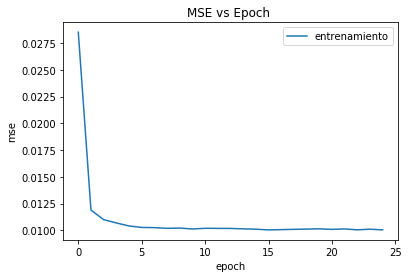

In [295]:
lag = 3
history = []

model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
history.append(model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1))
end_time = time.time()
print("Tiempo de entrenamiento: %f" % (end_time-start_time))

## Graficar el error, con el objetivo de visualiar de forma gráfica sus valores.
_ = plt.close('all')
_ = plt.title('MSE vs Epoch ')
_ = plt.plot(history[0].history['loss'])
_ = plt.xlabel('epoch')
_ = plt.ylabel('mse')
_ = plt.legend(['entrenamiento'], loc='upper right')
plt.show()

### f) Predicciones del modelo para los conjuntos de entrenamiento y prueba.  Datos desnormalizados para que el error pueda ser computado en la escala real.

In [296]:

batch_size = 1

##Para los datos de entrenamiento
trainPredict = model.predict(trainX,batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

##Para los datos de prueba
testPredict = model.predict(testX,batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

### g)  Cálculo de error RMSE (Root Mean Square Error) sobre el cojunto de entrenamiento y prueba 

In [297]:
##Cálculo de root mean square error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.43 RMSE


### h) Gráfico de las predicciones de train y test, contrastada con la serie de tiempo original. Muestra de un extracti de la predicción para ver en mas detalle como es la predicción. Comentarios
(FALTA EXTRACTO Y COMENTARIOS)


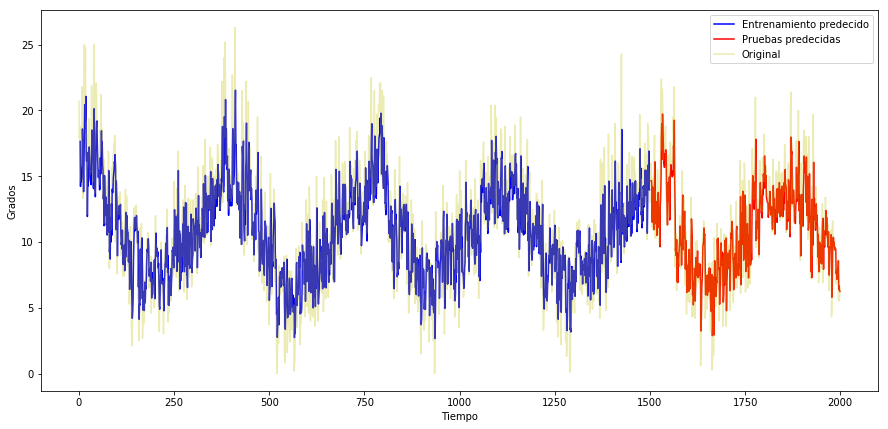

In [298]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

_ = plt.figure(figsize=(15,7))
_ = plt.plot(trainPredictPlot,'b')
_ = plt.plot(testPredictPlot,'r')
_ = plt.plot(dataframe.values,'y',alpha=0.3)
_ = plt.xlabel('Tiempo')
_ = plt.ylabel('Grados')
_ = plt.legend(['Entrenamiento predecido' , 'Pruebas predecidas','Original'], loc='upper right')
plt.show()


### i) En lugar de aumentar el número de dimensiones como el paso e),  se entrena  la red con un *timestep* de 3 (con dimensión de entrada 1). 

** ¿Se produce una mejora del error de entrenamiento y pruebas? **
** ¿Los tiempos de computación son comparables? **
** Comentar brevemente sobre cual es la forma correcta para aprovechar la información a través del tiempo, si con esta forma o la realizada en el paso e). **

In [304]:
lag = 3
## generando los datos de entrenamiento
trainX_i, trainY_i = create_dataset(stream_train_scaled, lag)
testX_i, testY_i   = create_dataset(stream_test_scaled , lag)

In [307]:
##dando la forma deseada [samples,time step,features]
trainX_i = np.reshape(trainX_i, (trainX_i.shape[0], trainX_i.shape[1],1))  ## reshape de trainX
testX_i  = np.reshape(testX_i,  (testX_i.shape[0] , testX_i.shape[1],1))   ## reshape de testX

print("Shape trainX")
trainX_i.shape
print("Shape testX")
testX_i.shape

trainY_i = np.reshape(trainY_i, (trainY_i.shape[0], 1)) ## reshape de trainY
testY_i = np.reshape(testY_i, (testY_i.shape[0], 1)) ##reshape de testY

print("Shape trainY")
trainY_i.shape
print("Shape testY")
testY_i.shape


Shape trainX


(1497, 3, 1)

Shape testX


(497, 3, 1)

Shape trainY


(1497, 1)

Shape testY


(497, 1)

/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  """


Epoch 1/25
1497/1497 [==============================] - 27s 18ms/step - loss: 0.0296
Epoch 2/25
1497/1497 [==============================] - 20s 13ms/step - loss: 0.0121
Epoch 3/25
1497/1497 [==============================] - 20s 13ms/step - loss: 0.0115
Epoch 4/25
1497/1497 [==============================] - 20s 14ms/step - loss: 0.0113
Epoch 5/25
1497/1497 [==============================] - 21s 14ms/step - loss: 0.0110
Epoch 6/25
1497/1497 [==============================] - 21s 14ms/step - loss: 0.0109
Epoch 7/25
1497/1497 [==============================] - 20s 14ms/step - loss: 0.0107
Epoch 8/25
1497/1497 [==============================] - 20s 13ms/step - loss: 0.0106
Epoch 9/25
1497/1497 [==============================] - 20s 13ms/step - loss: 0.0106
Epoch 10/25
1497/1497 [==============================] - 20s 13ms/step - loss: 0.0105
Epoch 11/25
1497/1497 [==============================] - 20s 13ms/step - loss: 0.0105
Epoch 12/25
1497/1497 [==============================] - 20s 13

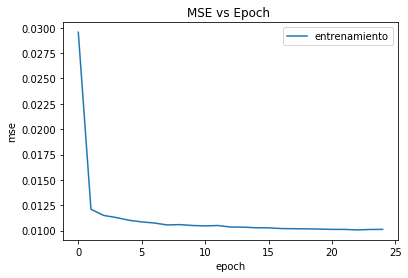

In [309]:
lag = 3
history_i = []

model_i = Sequential()
model_i.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid'))
model_i.add(Dense(1,activation='linear'))
model_i.compile(loss='mean_squared_error', optimizer='adam')
start_time_i = time.time()
history_i.append(model_i.fit(trainX_i, trainY_i, epochs=25, batch_size=1, verbose=1))
end_time_i = time.time()
print("Tiempo de entrenamiento: %f" % (end_time_i-start_time_i))

## Graficar el error, con el objetivo de visualiar de forma gráfica sus valores.
_ = plt.close('all')
_ = plt.title('MSE vs Epoch ')
_ = plt.plot(history_i[0].history['loss'])
_ = plt.xlabel('epoch')
_ = plt.ylabel('mse')
_ = plt.legend(['entrenamiento'], loc='upper right')
plt.show()

** Predicciones del modelo **

In [310]:
batch_size = 1

##Para los datos de entrenamiento
trainPredict_i = model_i.predict(trainX_i,batch_size=batch_size)
trainPredict_i = scaler.inverse_transform(trainPredict_i)
trainY_i = scaler.inverse_transform(trainY_i)

##Para los datos de prueba
testPredict_i = model_i.predict(testX_i,batch_size=batch_size)
testPredict_i = scaler.inverse_transform(testPredict_i)
testY_i = scaler.inverse_transform(testY_i)

** Cálculo del error RMSE **

In [311]:
##Cálculo de root mean square error
trainScore_i = math.sqrt(mean_squared_error(trainY_i, trainPredict_i[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_i))
testScore_i = math.sqrt(mean_squared_error(testY_i, testPredict_i[:,0]))
print('Test Score: %.2f RMSE' % (testScore_i))

Train Score: 2.62 RMSE
Test Score: 2.42 RMSE


** Grafico de predicción **

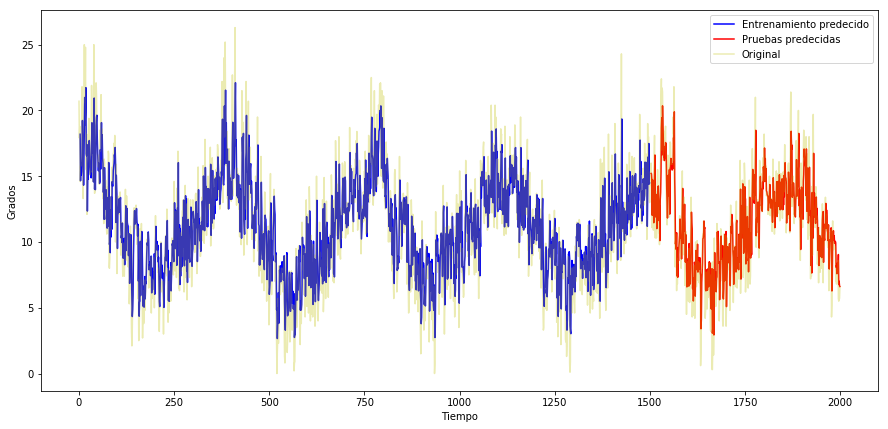

In [312]:
# shift train predictions for plotting
trainPredictPlot_i = np.empty_like(dataframe.values)
trainPredictPlot_i[:, :] = np.nan
trainPredictPlot_i[lag:len(trainPredict_i)+lag, :] = trainPredict_i

# shift test predictions for plotting
testPredictPlot_i = np.empty_like(dataframe.values)
testPredictPlot_i[:, :] = np.nan
testPredictPlot_i[(len(trainPredict_i)+2*lag):, :] = testPredict_i

_ = plt.figure(figsize=(15,7))
_ = plt.plot(trainPredictPlot_i,'b')
_ = plt.plot(testPredictPlot_i,'r')
_ = plt.plot(dataframe.values,'y',alpha=0.3)
_ = plt.xlabel('Tiempo')
_ = plt.ylabel('Grados')
_ = plt.legend(['Entrenamiento predecido' , 'Pruebas predecidas','Original'], loc='upper right')
plt.show()

** Forma correcta para aprvovechar la información a través del tiempo **

De acuerdo a los resultados, la forma correcta corresponde a la realizada en este paso, por .... FALTA

### j) Determine el parámetro del número de bloques para la LSTM de la pregunta e) o i), lo que le parezca mas sensato en base a lo analizado en la pregunta anterior. 
### Utilice 5-fold *cross validation*, o bien, en su defecto, los datos restante no utilizados ni como entrenamiento ni como pruebas (los de índice 2000 hacia adelante) como conjunto fijo de validación. Comente.

** Se utiliza el modelo de la pregunta i) y 5-fold cross validation **

In [233]:
trainX.shape
trainY.shape

(1497, 3, 1)

(1497, 1)

In [235]:
from sklearn import cross_validation

kfold = cross_validation.KFold(len(trainX_i), 5)

nb = [4] #range(4, 13, 2)
chosen_dim = 1  ## de acuerdo a respuesta i)
for n in nb:
    print("n: %d" % n)
    cvscores = []
    for train_idx, evaluate_idx in kfold:
        print("train index: %s" % len(train_idx))       
        print("evaluate index: %s" % len(evaluate_idx))
        model = Sequential()
        model.add(LSTM(n, input_dim=chosen_dim, activation='tanh',inner_activation='sigmoid'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])
        model.fit(trainX_i[train_idx], trainY_i[train_idx], epochs=2, batch_size=1, verbose=1) #epochs = 25
        scores = model.evaluate(trainX_i[evaluate_idx], trainY_i[evaluate_idx], verbose=0)        
        print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
        cvscores.append(scores[1] * 100)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
        
    

n: 4
train index: 1196
evaluate index: 300


/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  


Epoch 1/2
1196/1196 [==============================] - 25s 21ms/step - loss: 0.0138 - acc: 0.0025
Epoch 2/2
1196/1196 [==============================] - 19s 16ms/step - loss: 0.0117 - acc: 0.0025


loss: 1.04%
train index: 1197
evaluate index: 299
Epoch 1/2
1197/1197 [==============================] - 24s 20ms/step - loss: 0.0352 - acc: 8.3542e-04
Epoch 2/2
1197/1197 [==============================] - 20s 17ms/step - loss: 0.0121 - acc: 8.3542e-04


loss: 1.52%
train index: 1197
evaluate index: 299
Epoch 1/2
1197/1197 [==============================] - 27s 23ms/step - loss: 0.0231 - acc: 0.0017
Epoch 2/2
1197/1197 [==============================] - 19s 16ms/step - loss: 0.0121 - acc: 0.0025


loss: 1.16%
train index: 1197
evaluate index: 299
Epoch 1/2
1197/1197 [==============================] - 25s 21ms/step - loss: 0.0234 - acc: 0.0017
Epoch 2/2
1197/1197 [==============================] - 19s 16ms/step - loss: 0.0122 - acc: 0.0017


loss: 1.02%
train index: 1197
evaluate index: 299
Epoch 1/2
1197/1197 [==============================] - 24s 20ms/step - loss: 0.0398 - acc: 0.0025
Epoch 2/2
1197/1197 [==============================] - 20s 17ms/step - loss: 0.0136 - acc: 0.0025


loss: 1.20%
0.20% (+/- 0.27%)


## Falta comentar y ver como mostrar los resultados 

### K) Comparando el desempeño de la red LSTM variando el lag de 1  a  4. Comentar que resulta mejor, tener más información para predecir o esto satura la predicción por el efecto del gradiente descendiente.

In [236]:
lag_value = [1,2,3,4]
for lag_v in lag_value:   
    print("Lag %s "  % (lag_v))
    trainX, trainY = create_dataset(stream_train_scaled_Orig, lag_v)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1)) ## reshape de considerando la eleeción opción i)
    trainY = np.reshape(trainY, (trainY.shape[0],1))

    model = Sequential()
    model.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid')) ## input_dim al elegir opción i)
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=1) ##epochs 25

Lag 1 


/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  if __name__ == '__main__':


Epoch 1/1
1499/1499 [==============================] - 18s 12ms/step - loss: 0.0279


Lag 2 
Epoch 1/1
1498/1498 [==============================] - 21s 14ms/step - loss: 0.0412


Lag 3 
Epoch 1/1
1497/1497 [==============================] - 25s 17ms/step - loss: 0.0126


Lag 4 
Epoch 1/1
1496/1496 [==============================] - 30s 20ms/step - loss: 0.0185


## Falta comentar y ver como mostrar los resultados 

### l) Usando un lag de 3, compare el desempeño de la LSTM con una red recurrente simple y una GRU, comente sobre convergencia y tiempo de ejecución

In [247]:
# from keras.layers import GRU
from keras.layers import SimpleRNN

#f, axarr_train = plt.subplots(2, sharex=True,sharey =True,figsize=(12,12))

historyGRU = []
historySimpleRNN = []

lag = 3
trainX, trainY = create_dataset(stream_train_scaled_Orig, lag)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1)) ## reshape de considerando la eleeción opción i)
trainY = np.reshape(trainY, (trainY.shape[0], 1))

## Verificando los datos, para utilizar modelo i)
trainX.shape
trainY.shape

## Red GRU
model = Sequential()
model.add(GRU(4, input_dim=1, inner_init='orthogonal', activation='tanh')) ## input_dim al elegir opción i)
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time_GRU = time.time()
historyGRU.append(model.fit(trainX, trainY, epochs=2, batch_size=1, verbose=1))
end_time_GRU = time.time()

## Red recurrente simple
model = Sequential()
model.add(SimpleRNN(4, input_dim=1, inner_init='orthogonal',activation='tanh')) ## input_dim al elegir opción i)
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time_SimpleRNN = time.time()
historySimpleRNN.append(model.fit(trainX, trainY, epochs=2, batch_size=1, verbose=1))
end_time_SimpleRNN = time.time()

timeGRU = end_time_GRU - start_time_GRU
timeSimpleRNN = end_time_SimpleRNN - start_time_SimpleRNN

(1497, 3, 1)

(1497, 1)

/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(4, activation="tanh", input_shape=(None, 1), recurrent_initializer="orthogonal")`


Epoch 1/2
1497/1497 [==============================] - 29s 19ms/step - loss: 0.0158
Epoch 2/2
1497/1497 [==============================] - 22s 15ms/step - loss: 0.0109


/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(4, activation="tanh", input_shape=(None, 1), recurrent_initializer="orthogonal")`


Epoch 1/2
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0128
Epoch 2/2
1497/1497 [==============================] - 9s 6ms/step - loss: 0.0113


In [248]:
print("Tiempo de ejecución")
print("Tiempo GRU %f" % (timeGRU))
print("Tiempo SimpleRNN %f" % (timeSimpleRNN))

Tiempo de ejecución
Tiempo GRU 51.116825
Tiempo SimpleRNN 25.477100


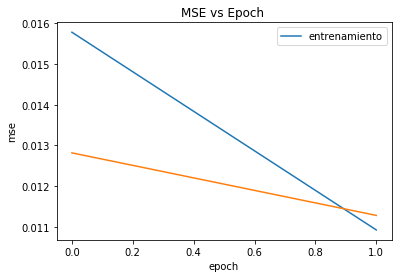

In [249]:
## Graficar el error, con el objetivo de visualiar de forma gráfica sus valores.
_ = plt.close('all')
_ = plt.title('MSE vs Epoch ')
_ = plt.plot(historyGRU[0].history['loss'])
_ = plt.plot(historySimpleRNN[0].history['loss'])
_ = plt.xlabel('epoch')
_ = plt.ylabel('mse')
_ = plt.legend(['entrenamiento'], loc='upper right')
plt.show()

Con respecto al tiempo de convergencia se observa que ...

# m) Entrenando la red con memoria entre batches. Gráfico de predicción, comentarios con respecto a si mejora la predicción

In [259]:
## Se utiliza modelo de i)
trainX.shape
trainY.shape

lag = 3
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(25): ## 5 cambiar por 25
    print("batch_size %s" % (i))
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states() #clears only the hidden states of the network

(1497, 3, 1)

(1497, 1)

batch_size 0


batch_size 1


batch_size 2


batch_size 3


batch_size 4


batch_size 5


batch_size 6


batch_size 7


batch_size 8


batch_size 9


batch_size 10


batch_size 11


batch_size 12


batch_size 13


batch_size 14


batch_size 15


batch_size 16


batch_size 17


batch_size 18


batch_size 19


batch_size 20


batch_size 21


batch_size 22


batch_size 23


batch_size 24


** Predicción del modelo ** ... ¿Debiese ser para cada batch_size?

In [260]:
batch_size = 1

##Para los datos de entrenamiento
trainPredict = model.predict(trainX,batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

##Para los datos de prueba
testPredict = model.predict(testX,batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

** Cálculo de error MSE ** ... ¿ídem a anterior?

In [261]:
##Cálculo de root mean square error
trainScore_i = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore_i = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.73 RMSE
Test Score: 2.54 RMSE


** Gráfico de predicciones, vs entrenamiento **

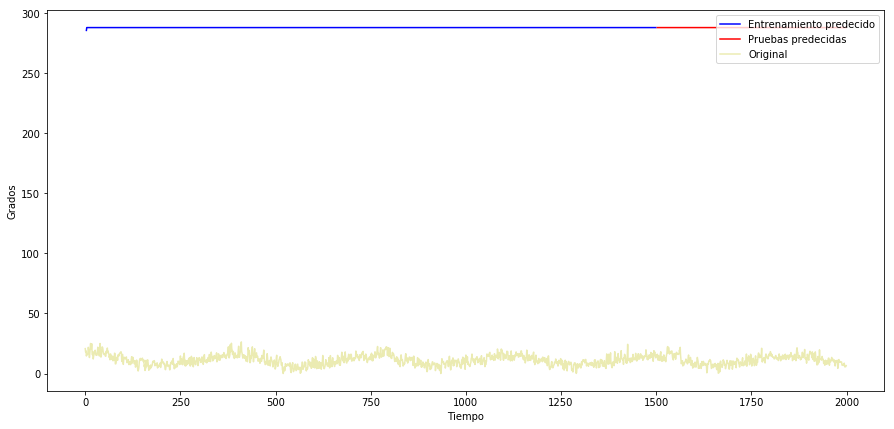

In [262]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict

_ = plt.figure(figsize=(15,7))
_ = plt.plot(trainPredictPlot,'b')
_ = plt.plot(testPredictPlot,'r')
_ = plt.plot(dataframe.values,'y',alpha=0.3)
_ = plt.xlabel('Tiempo')
_ = plt.ylabel('Grados')
_ = plt.legend(['Entrenamiento predecido' , 'Pruebas predecidas','Original'], loc='upper right')
plt.show()

** Comentarios ¿Mejora la predicción? **

### n) Comprar resultados anterior usando un tamaño de batch a elección, mayor o igual a 3

In [ ]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid')) ## input_dim al elegir opción i)
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=1) ##epochs 25

### o) LSTM apilada, y comparacion con modelo de i). Comentarios

In [270]:
trainX.shape
trainY.shape

model = Sequential()
model.add(LSTM(4, input_dim=1, return_sequences=True))
model.add(LSTM(4))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
model.fit(trainX, trainY, epochs=2, batch_size=1, verbose=1) ## cambiar epochs a 25
end_time = time.time()

(1497, 3, 1)

(1497, 1)

/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/anaconda3/envs/redes-neuronales/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, return_sequences=True, input_shape=(None, 1))`
  """


ValueError: Error when checking target: expected lstm_99 to have shape (4,) but got array with shape (1,)